In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv

MAINPATH = '/Users/research/projects/maiasaurus/'

# Build the observed catalogue

In [2]:
# READ IN OBSERVED PLANETS
obs_file = MAINPATH + 'catalogues/epos_transiting_planets_raw_output.csv'

obs_data = []
with open(obs_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        obs_data.append(row)
        
KEYS = obs_data[0]
VALUES = obs_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [3]:
obs = {}

obs['star_id'] = getkey('# starID')
obs['period']  = getkey('Period_days')
obs['radius']  = getkey('Radius_earth')
obs['tdur']    = getkey('Duration_hours')/24

obs['rhostar'] = np.ones_like(obs['period'])
obs['rstar']   = np.ones_like(obs['period'])
obs['mstar']   = np.ones_like(obs['period'])

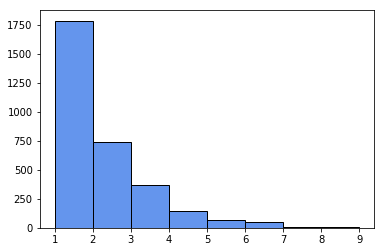

In [4]:
npl = np.zeros_like(obs['star_id'], dtype='int')

for i, sid in enumerate(obs['star_id']):
    npl[i] = np.sum(obs['star_id'] == sid)

obs['npl'] = npl
    
plt.figure()
plt.hist(npl, bins=np.arange(1,npl.max()+1), color='cornflowerblue', edgecolor='k')
plt.show()

In [5]:
print('%d planets in OBSERVED catalogue' %len(obs['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_observed_planets.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(obs.keys())
        writer.writerows(zip(*obs.values()))

3176 planets in OBSERVED catalogue


# Build the underlying physical catalogue

In [6]:
# READ IN PHYSICAL PLANETS
phys_file = MAINPATH + 'catalogues/epos_transiting_systems_raw_output.csv'

phys_data = []
with open(phys_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        phys_data.append(row)
        
KEYS = phys_data[0]
VALUES = phys_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [7]:
phys = {}

phys['star_id'] = getkey('# starID')
phys['period']  = getkey('Period_days')
phys['radius']  = getkey('Radius_earth')
phys['tdur']    = getkey('Duration_hours')/24

phys['rhostar'] = np.ones_like(phys['period'])
phys['rstar']   = np.ones_like(phys['period'])
phys['mstar']   = np.ones_like(phys['period'])

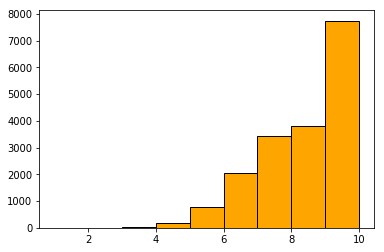

In [8]:
npl = np.zeros_like(phys['star_id'], dtype='int')

for i, sid in enumerate(phys['star_id']):
    npl[i] = np.sum(phys['star_id'] == sid)

phys['npl'] = npl
    
plt.figure()
plt.hist(npl, bins=np.arange(1,npl.max()+1), color='orange', edgecolor='k')
plt.show()

In [9]:
print('%d planets in PHYSICAL catalogue' %len(phys['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_physical_planets.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(phys.keys())
        writer.writerows(zip(*phys.values()))

18039 planets in PHYSICAL catalogue


# Isolate the undetected planets

In [10]:
und = phys.copy()

in_observed_catalogue = np.isin(phys['period'], obs['period'])

for k in und.keys():
    und[k] = und[k][~in_observed_catalogue]

In [11]:
print('%d planets in UNDETECTED catalogue' %len(und['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_undetected_planets.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(und.keys())
        writer.writerows(zip(*und.values()))

14863 planets in UNDETECTED catalogue


# Apply limit cuts to the undetected objects

In [12]:
# restore all the physical planets
und = phys.copy()

In [13]:
# first remove long period planets (P > 400)
keep = (und['period'] <= 400.)

for k in und.keys():
    und[k] = und[k][keep]
    
print('%d long-period planets (P > 400d) discarded' %np.sum(~keep))

1842 long-period planets (P > 400d) discarded


In [14]:
# update number of planets in each system to reflect removals
uniquesys = np.unique(und['star_id'])

for us in uniquesys:
    und['npl'][und['star_id']==us] = int(np.sum(und['star_id']==us))

    
# remove systems with fewer than 3 planets
npl = und['npl'].copy()

for k in und.keys():
    und[k] = und[k][npl >= 3]
    
print('%d systems removed after being reduced to less than 3 planets' %np.sum(npl <= 3))

142 systems removed after being reduced to less than 3 planets


In [15]:
# elimnate SYSTEMS which do not match period (P > 2) or radius (R < 6) limits
bad_planet = (und['radius'] > 6.0) + (und['period'] < 2.0)
bad_system = np.zeros_like(bad_planet)


uniquesys = np.unique(und['star_id'])

for us in uniquesys:
    bad_system[und['star_id']==us] = int(np.sum(bad_planet[und['star_id']==us]))

for k in und.keys():
    und[k] = und[k][~bad_system]
    
print('%d systems discarded with undetected planets outside valid range' %(len(uniquesys)-len(np.unique(und['star_id']))))

656 systems discarded with undetected planets outside valid range


In [16]:
# check for SYSTEMS which do not match limits for detected planets either
bad_planet = (obs['radius'] > 6.0) + (obs['period'] < 2.0)
bad_system = np.isin(und['star_id'], obs['star_id'][bad_planet])

uniquesys = np.unique(und['star_id'])

for k in und.keys():
    und[k] = und[k][~bad_system]
    
print('%d systems discarded with observed planets outside valid range' %(len(uniquesys)-len(np.unique(und['star_id']))))

3 systems discarded with observed planets outside valid range


In [17]:
# seperate out the undetected planets
in_observed_catalogue = np.isin(und['period'], obs['period'])

for k in und.keys():
    und[k] = und[k][~in_observed_catalogue]

In [18]:
print('%d planets in LIMITED UNDETECTED catalogue' %len(und['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_undetected_planets_with_limit_cuts.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(und.keys())
        writer.writerows(zip(*und.values()))

8610 planets in LIMITED UNDETECTED catalogue


# Apply limit cuts to the observed objects

In [19]:
# first remove long period planets (P > 400)
keep = (obs['period'] <= 400.)

for k in obs.keys():
    obs[k] = obs[k][keep]
    
print('%d long-period planets (P > 400d) discarded' %np.sum(~keep))

6 long-period planets (P > 400d) discarded


In [20]:
# next remove small planets (R < 0.5)
keep = (obs['radius'] >= 0.5)

for k in obs.keys():
    obs[k] = obs[k][keep]
    
print('%d small planets (rp/Re < 0.5) discarded' %np.sum(~keep))

18 small planets (rp/Re < 0.5) discarded


In [21]:
# update number of planets in each system to reflect removals
uniquesys = np.unique(obs['star_id'])

for us in uniquesys:
    obs['npl'][obs['star_id']==us] = int(np.sum(obs['star_id']==us))

    
# remove systems reduced to less than 3 planets
npl = obs['npl'].copy()

for k in obs.keys():
    obs[k] = obs[k][npl >= 3]
    
print('%d systems removed after being reduced to less than 3 planets' %np.sum(npl < 3))

2499 systems removed after being reduced to less than 3 planets


In [22]:
# finally elimnate SYSTEMS which do not match period (P > 2) or radius (R < 6) limits
bad_planet = (obs['radius'] > 6.0) + (obs['period'] < 2.0)
bad_system = np.zeros_like(bad_planet)


uniquesys = np.unique(obs['star_id'])

for us in uniquesys:
    bad_system[obs['star_id']==us] = int(np.sum(bad_planet[obs['star_id']==us]))

for k in obs.keys():
    obs[k] = obs[k][~bad_system]
    
print('%d systems discarded' %(len(uniquesys)-len(np.unique(obs['star_id']))))

74 systems discarded


In [23]:
print('%d planets in LIMITED OBSERVED catalogue' %len(obs['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_observed_planets_with_limit_cuts.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(obs.keys())
        writer.writerows(zip(*obs.values()))

380 planets in LIMITED OBSERVED catalogue


# Read in masses and combine for OBSERVED MULTIS

In [24]:
# READ IN EPOS DATABASE
epos_file = MAINPATH + 'catalogues/epos_observed_planets.csv'

epos_data = []
with open(epos_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        epos_data.append(row)
        
KEYS = epos_data[0]
VALUES = epos_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [25]:
# PULL RELEVANT QUANTITIES FROM CATALOGUE
epos = {}

epos['star_id'] = np.array(getkey('star_id'), dtype='int')

epos['period'] = getkey('period')
epos['radius'] = getkey('radius')
epos['tdur']   = getkey('tdur')

epos['rhostar'] = np.ones_like(epos['period'])
epos['rstar']   = np.ones_like(epos['period'])
epos['mstar']   = np.ones_like(epos['period'])

epos['npl'] = np.array(getkey('npl'), dtype='int')

In [26]:
# remove single-planet systems
epos_npl = epos['npl'].copy()

for k in epos.keys():
    epos[k] = epos[k][epos_npl > 1]

In [29]:
r1 = epos['radius']
r2 = np.load(MAINPATH + 'catalogues/epos_observed_pred_masses_oct22.npy')[0]

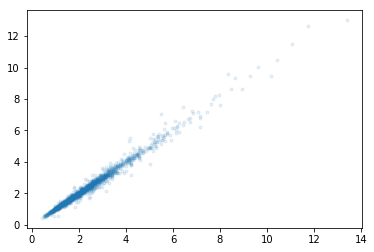

In [30]:
plt.figure()
plt.plot(r1, r2, '.', alpha=0.1)
plt.show()

In [31]:
err = (r1-r2)/r1

print(np.median(err), np.std(err))

-0.004518297204525764 0.06947544091649573


In [ ]:
# read in mass
epos['mass'] = np.load(MAINPATH + 'catalogues/epos_observed_pred_masses_oct22.npy')[3]

In [ ]:
print('%d planets in OBSERVED MULTIS catalogue' %len(epos['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_observed_multis_with_masses.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(epos.keys())
        writer.writerows(zip(*epos.values()))

# Read in masses and combine for UNDETECTED MULTIS

In [ ]:
# READ IN EPOS DATABASE
epos_file = MAINPATH + 'catalogues/epos_undetected_planets_with_limit_cuts.csv'

epos_data = []
with open(epos_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        epos_data.append(row)
        
KEYS = epos_data[0]
VALUES = epos_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [ ]:
# PULL RELEVANT QUANTITIES FROM CATALOGUE
epos = {}

epos['star_id'] = np.array(getkey('star_id'), dtype='int')

epos['period'] = getkey('period')
epos['radius'] = getkey('radius')
epos['tdur']   = getkey('tdur')

epos['rhostar'] = np.ones_like(epos['period'])
epos['rstar']   = np.ones_like(epos['period'])
epos['mstar']   = np.ones_like(epos['period'])

epos['npl'] = np.array(getkey('npl'), dtype='int')

In [ ]:
# remove single-planet systems
epos_npl = epos['npl'].copy()

for k in epos.keys():
    epos[k] = epos[k][epos_npl > 1]

In [ ]:
# read in mass
epos['mass'] = np.load(MAINPATH + 'catalogues/epos_undetected_pred_masses_dec11.npy')[3]

In [ ]:
print('%d planets in UNDETECTED MULTIS catalogue' %len(epos['star_id']))

WRITENEW = True
if WRITENEW:
    filepath = MAINPATH + 'catalogues/epos_undetected_multis_with_masses.csv'

    with open(filepath, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(epos.keys())
        writer.writerows(zip(*epos.values()))